# 제조 라인 이상(불량) 탐지 프로젝트
# Manufacturing Line Anomaly Detection Project

---

## 문제 개요 / Problem Overview

제조 라인에서 발생하는 최종 불량(EOL Fail)을 예측하기 위해 **지도 학습**과 **비지도 학습**을 결합하여 이상 발생 위험도를 확률(score) 형태로 산출하고, 운영 현장에 적용 가능한 임계값 기준(Threshold Policy)을 제시합니다.

### 평가 항목 / Evaluation Criteria
| 구분 | 요구 수준 |
|------|----------|
| 데이터 탐색 | 구조, 분포, 불균형 분석 |
| 전처리 | 범주형/수치형 분리 및 변환 |
| 피처 추출 | **비지도 표현 학습** 또는 자체 피처 엔지니어링 |
| 모델링 | 분류 모델 자유 선택 |
| 임계값 탐색 | F1 최적 vs Top 5% 비교 |
| 코드 완결성 | 오류 없이 실행 가능한 구조 |

---
## 0. 환경 설정 / Environment Setup

In [43]:
# ============================================================
# 라이브러리 임포트 / Library Imports
# ============================================================
# 기본 라이브러리 / Standard libraries
import os
import random
import warnings
from pathlib import Path

# 데이터 처리 및 시각화 / Data processing and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 머신러닝 라이브러리 / Machine learning libraries
from sklearn.model_selection import train_test_split  # 데이터 분할 / Data splitting
from sklearn.preprocessing import StandardScaler  # 표준화 / Standardization
from sklearn.decomposition import PCA  # 주성분 분석 / Principal Component Analysis
from sklearn.cluster import KMeans  # K-평균 클러스터링 / K-Means Clustering
from sklearn.ensemble import IsolationForest  # 이상치 탐지 / Anomaly detection

# 평가 지표 / Evaluation metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, classification_report,
    confusion_matrix, precision_recall_curve
)

# 불균형 데이터 처리 / Imbalanced data handling
from imblearn.over_sampling import SMOTE

# 그래디언트 부스팅 모델 / Gradient boosting model
from xgboost import XGBClassifier

# 경고 메시지 숨김 / Suppress warning messages
warnings.filterwarnings('ignore')

# 시각화 설정 / Visualization settings
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style('whitegrid')

print('✅ 라이브러리 로드 완료 / Libraries loaded successfully')

✅ 라이브러리 로드 완료 / Libraries loaded successfully


In [44]:
# ============================================================
# 재현성을 위한 시드 설정 / Set random seed for reproducibility
# ============================================================
# 동일한 결과를 얻기 위해 모든 난수 생성기에 시드 설정
# Set seed for all random number generators to ensure consistent results
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

print(f'✅ 랜덤 시드 설정 완료 / Random seed set: {SEED}')

✅ 랜덤 시드 설정 완료 / Random seed set: 42


---
## 1️⃣ 데이터 로딩 및 탐색

In [45]:
# ============================================================
# 데이터 로딩 / Data Loading
# ============================================================
# CSV 파일 경로 설정 / Set CSV file path
CSV_PATH = Path('manufacturing_error_dataset_v2.csv')

# 파일이 없으면 Google Drive에서 다운로드
# Download from Google Drive if file doesn't exist
if not CSV_PATH.exists():
    import gdown
    gdown.download(
        'https://drive.google.com/uc?id=1GPFqmquPgvcLQQqSem3OPhR-hT7zStB2',
        str(CSV_PATH),
        quiet=False
    )

# 데이터프레임 로드 / Load dataframe
df = pd.read_csv(CSV_PATH)
print(f'데이터 Shape / Data Shape: {df.shape}')

# ============================================================
# 컬럼 분류 / Column Classification
# ============================================================
# 타겟 변수 / Target variable
TARGET_COL = 'eol_fail'

# 범주형 변수: 라인ID, 교대조, 공급업체, 자재 등급
# Categorical variables: Line ID, Shift, Supplier, Material Grade
CAT_COLS = ['line_id', 'shift', 'supplier', 'material_grade']

# 수치형 변수: 타겟과 범주형을 제외한 모든 컬럼
# Numeric variables: All columns except target and categorical
NUM_COLS = [c for c in df.columns if c not in CAT_COLS + [TARGET_COL]]

print(f'타겟 / Target: {TARGET_COL}')
print(f'범주형 / Categorical ({len(CAT_COLS)}): {CAT_COLS}')
print(f'수치형 / Numeric ({len(NUM_COLS)}): {NUM_COLS}')

데이터 Shape / Data Shape: (2500, 16)
타겟 / Target: eol_fail
범주형 / Categorical (4): ['line_id', 'shift', 'supplier', 'material_grade']
수치형 / Numeric (11): ['machine_age_months', 'last_maint_days', 'operator_experience_yrs', 'ambient_temp_c', 'ambient_humidity_pct', 'vibration_rms', 'hydraulic_pressure_bar', 'defect_history_count_90d', 'prev_batch_quality_score', 'tool_wear_mm', 'scrap_rate_pct_line_week']


결측치 / Missing values: 0

Class 0 (정상/Normal): 2,125개 (85.0%)
Class 1 (불량/Defect): 375개 (15.0%)
불균형 비율 / Imbalance ratio: 5.67:1


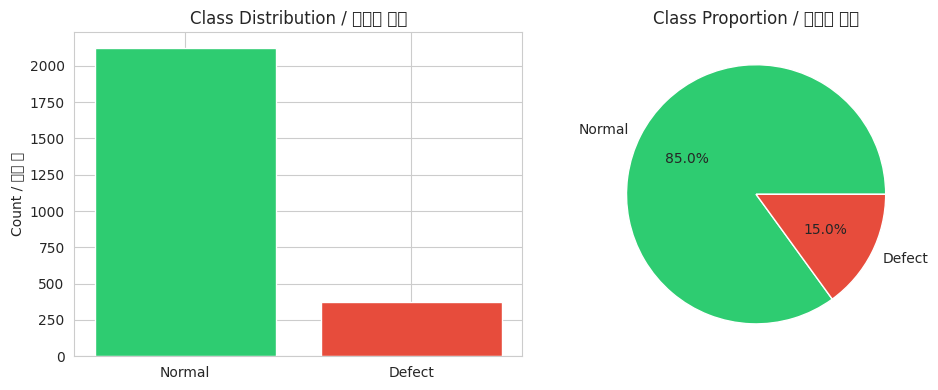

In [46]:
# ============================================================
# 결측치 및 클래스 불균형 분석 / Missing Values & Class Imbalance Analysis
# ============================================================
# 결측치 확인 / Check for missing values
print(f'결측치 / Missing values: {df.isnull().sum().sum()}')

# 클래스별 샘플 수 계산 / Calculate samples per class
class_counts = df[TARGET_COL].value_counts().sort_index()
class_ratio = class_counts / len(df) * 100

# 불균형 비율 (정상:불량) / Imbalance ratio (Normal:Defect)
imbalance_ratio = class_counts[0] / class_counts[1]

print(f'\nClass 0 (정상/Normal): {class_counts[0]:,}개 ({class_ratio[0]:.1f}%)')
print(f'Class 1 (불량/Defect): {class_counts[1]:,}개 ({class_ratio[1]:.1f}%)')
print(f'불균형 비율 / Imbalance ratio: {imbalance_ratio:.2f}:1')

# ============================================================
# 클래스 분포 시각화 / Class Distribution Visualization
# ============================================================
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# 막대 그래프 / Bar chart
ax[0].bar(['Normal', 'Defect'], class_counts.values, color=['#2ecc71', '#e74c3c'])
ax[0].set_title('Class Distribution / 클래스 분포')
ax[0].set_ylabel('Count / 샘플 수')

# 파이 차트 / Pie chart
ax[1].pie(
    class_counts.values, 
    labels=['Normal', 'Defect'], 
    autopct='%1.1f%%', 
    colors=['#2ecc71', '#e74c3c']
)
ax[1].set_title('Class Proportion / 클래스 비율')

plt.tight_layout()
plt.show()

In [47]:
# ============================================================
# 수치형 변수 기술통계 / Descriptive Statistics for Numeric Variables
# ============================================================
# 수치형 컬럼의 기본 통계량 출력
# Display basic statistics for numeric columns
# - count: 샘플 수 / Sample count
# - mean: 평균 / Mean
# - std: 표준편차 / Standard deviation  
# - min/max: 최솟값/최댓값 / Min/Max values
# - 25%/50%/75%: 사분위수 / Quartiles
print(df[NUM_COLS].describe().T.round(3))

                           count     mean     std     min      25%      50%  \
machine_age_months        2500.0   89.319  51.666   3.000   44.000   89.000   
last_maint_days           2500.0   60.434  34.297   1.000   30.000   61.000   
operator_experience_yrs   2500.0    5.849   3.422   0.000    2.800    5.800   
ambient_temp_c            2500.0   24.093   4.495   6.500   21.000   24.000   
ambient_humidity_pct      2500.0   55.573  11.944  15.900   47.875   55.500   
vibration_rms             2500.0    1.832   0.609   0.028    1.405    1.825   
hydraulic_pressure_bar    2500.0  115.132  11.768  76.700  107.300  115.250   
defect_history_count_90d  2500.0    1.196   1.118   0.000    0.000    1.000   
prev_batch_quality_score  2500.0   91.979   4.861  75.800   88.700   92.200   
tool_wear_mm              2500.0    0.352   0.175   0.020    0.227    0.347   
scrap_rate_pct_line_week  2500.0    2.829   1.463   0.000    1.800    2.810   

                              75%      max  
machin

---
## 2️⃣ 피처 추출 및 전처리

In [48]:
# ============================================================
# Train/Validation 분할 / Train/Validation Split
# ============================================================
# 특성과 타겟 분리 / Separate features and target
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL].astype(int)

# Stratified 분할로 클래스 비율 유지 (80:20)
# Stratified split to maintain class distribution (80:20)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, 
    test_size=0.2,  # 검증 데이터 20% / 20% for validation
    random_state=SEED, 
    stratify=y  # 클래스 비율 유지 / Maintain class ratio
)

# 검증 데이터 원본 보존 (나중에 리포트용)
# Preserve original validation data for later reporting
X_valid_original = X_valid.copy()

print(f'Train: {X_train.shape[0]}개, Valid: {X_valid.shape[0]}개')
print(f'Train: {X_train.shape[0]} samples, Valid: {X_valid.shape[0]} samples')

Train: 2000개, Valid: 500개
Train: 2000 samples, Valid: 500 samples


In [ ]:
# ============================================================
# 이상치 탐지 및 제거 (IQR 방식) / Outlier Detection & Removal (IQR Method)
# ============================================================
def detect_outliers_iqr(df, columns, threshold=1.5):
    """
    IQR 방식으로 이상치 인덱스를 탐지합니다.
    Detect outlier indices using the IQR (Interquartile Range) method.
    
    Args:
        df: 데이터프레임 / DataFrame to analyze
        columns: 검사할 컬럼 리스트 / List of columns to check
        threshold: IQR 배수 (기본값 1.5) / IQR multiplier (default 1.5)
    
    Returns:
        이상치가 있는 행의 인덱스 집합 / Set of row indices containing outliers
        각 컬럼별 이상치 인덱스 집합 반환 / Return set of outlier indices for each column
    """
    outlier_indices = set()
    for col in columns:
        # 사분위수 계산 / Calculate quartiles
        Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # 경계값 벗어나는 샘플 찾기 / Find samples outside boundaries
        # 하한: Q1 - 1.5*IQR, 상한: Q3 + 1.5*IQR
        col_outliers = df[
            (df[col] < Q1 - threshold * IQR) | 
            (df[col] > Q3 + threshold * IQR)
        ].index
        outlier_indices.update(col_outliers)
    return outlier_indices

# 학습/검증 데이터에서 이상치 탐지 / Detect outliers in train/valid data
train_outliers = detect_outliers_iqr(X_train, NUM_COLS)
valid_outliers = detect_outliers_iqr(X_valid, NUM_COLS)

# 이상치 제거 후 인덱스 리셋 / Remove outliers and reset index
X_train_clean = X_train.drop(index=list(train_outliers)).reset_index(drop=True)
y_train_clean = y_train.drop(index=list(train_outliers)).reset_index(drop=True)
X_valid_clean = X_valid.drop(index=list(valid_outliers)).reset_index(drop=True)
y_valid_clean = y_valid.drop(index=list(valid_outliers)).reset_index(drop=True)
X_valid_orig_clean = X_valid_original.drop(index=list(valid_outliers)).reset_index(drop=True)

print(f'이상치 제거 / Outlier removal: Train {len(X_train)}→{len(X_train_clean)}, Valid {len(X_valid)}→{len(X_valid_clean)}')

이상치 제거 / Outlier removal: Train 2000→1933, Valid 500→484


In [50]:
# ============================================================
# 범주형 인코딩 & 수치형 스케일링 / Categorical Encoding & Numeric Scaling
# ============================================================

# [1] 범주형 변수: One-Hot 인코딩 / Categorical: One-Hot Encoding
# 각 범주를 이진(0/1) 더미 변수로 변환
# Convert each category to binary (0/1) dummy variables
X_train_cat = pd.get_dummies(X_train_clean[CAT_COLS], columns=CAT_COLS, dtype=int)
X_valid_cat = pd.get_dummies(X_valid_clean[CAT_COLS], columns=CAT_COLS, dtype=int)

# 검증 데이터의 컬럼을 학습 데이터에 맞춤 (없는 컬럼은 0으로 채움)
# Align validation columns to training data (fill missing columns with 0)
X_valid_cat = X_valid_cat.reindex(columns=X_train_cat.columns, fill_value=0)

# [2] 수치형 변수: StandardScaler (Z-score 정규화)
# Numeric: StandardScaler (Z-score normalization)
# 평균=0, 표준편차=1로 변환 / Transform to mean=0, std=1
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train_clean[NUM_COLS])  # 학습 데이터로 fit / Fit on train
X_valid_num = scaler.transform(X_valid_clean[NUM_COLS])  # 검증 데이터는 transform만 / Only transform valid

# DataFrame으로 변환 / Convert to DataFrame
X_train_num_df = pd.DataFrame(X_train_num, columns=NUM_COLS)
X_valid_num_df = pd.DataFrame(X_valid_num, columns=NUM_COLS)

print(f'One-Hot 인코딩 / One-Hot Encoding: {X_train_cat.shape[1]} columns')
print(f'StandardScaler 적용 완료 / StandardScaler applied')

One-Hot 인코딩 / One-Hot Encoding: 16 columns
StandardScaler 적용 완료 / StandardScaler applied


In [51]:
# ============================================================
# 비지도 학습 기반 잠재 특징 추출 / Unsupervised Latent Feature Extraction
# ============================================================
# 비지도 학습으로 데이터의 숨겨진 패턴을 포착하여 추가 특성 생성
# Extract hidden patterns from data using unsupervised learning

# ------------------------------------------------------------
# [1] PCA (주성분 분석) / Principal Component Analysis
# ------------------------------------------------------------
# 고차원 데이터를 저차원으로 압축하여 주요 변동 패턴 포착
# Compress high-dimensional data to capture main variation patterns
pca = PCA(n_components=3, random_state=SEED)
pca_train = pca.fit_transform(X_train_num)
pca_valid = pca.transform(X_valid_num)
pca_train_df = pd.DataFrame(pca_train, columns=['pca_1', 'pca_2', 'pca_3'])
pca_valid_df = pd.DataFrame(pca_valid, columns=['pca_1', 'pca_2', 'pca_3'])

explained_var = sum(pca.explained_variance_ratio_) * 100
print(f'PCA 설명 분산 / PCA Explained Variance: {explained_var:.1f}%')

# ------------------------------------------------------------
# [2] Isolation Forest (이상치 점수) / Anomaly Score
# ------------------------------------------------------------
# 정상 데이터와 다른 정도를 점수화 (높을수록 이상)
# Score how different each sample is from normal (higher = more anomalous)
iso_forest = IsolationForest(
    n_estimators=100,  # 트리 개수 / Number of trees
    contamination=0.15,  # 예상 이상치 비율 / Expected outlier ratio
    random_state=SEED
)
iso_forest.fit(X_train_num)

# decision_function 부호 반전: 양수가 이상치가 되도록
# Negate decision_function: positive values indicate anomalies
iso_train_df = pd.DataFrame({'iso_anomaly_score': -iso_forest.decision_function(X_train_num)})
iso_valid_df = pd.DataFrame({'iso_anomaly_score': -iso_forest.decision_function(X_valid_num)})

# ------------------------------------------------------------
# [3] K-Means 클러스터링 / K-Means Clustering
# ------------------------------------------------------------
# 데이터를 K개 그룹으로 분할하고 클러스터 정보를 특성으로 활용
# Divide data into K groups and use cluster info as features
kmeans = KMeans(n_clusters=5, random_state=SEED, n_init=10)
kmeans.fit(X_train_num)

# cluster_label: 소속 클러스터 / Assigned cluster
# cluster_distance: 클러스터 중심까지 거리 / Distance to cluster centroid
cluster_train_df = pd.DataFrame({
    'cluster_label': kmeans.predict(X_train_num),
    'cluster_distance': kmeans.transform(X_train_num).min(axis=1)
})
cluster_valid_df = pd.DataFrame({
    'cluster_label': kmeans.predict(X_valid_num),
    'cluster_distance': kmeans.transform(X_valid_num).min(axis=1)
})

print(f'비지도 잠재 특징 / Unsupervised latent features: PCA(3) + IsolationForest(1) + KMeans(2) = 6')

PCA 설명 분산 / PCA Explained Variance: 29.3%


비지도 잠재 특징 / Unsupervised latent features: PCA(3) + IsolationForest(1) + KMeans(2) = 6


In [52]:
# ============================================================
# 최종 피처셋 구성 / Compose Final Feature Set
# ============================================================
# 모든 전처리된 특성을 하나의 데이터프레임으로 결합
# Combine all preprocessed features into a single dataframe

# 인덱스 리셋 (concat 시 정렬 문제 방지)
# Reset indices to prevent alignment issues during concat
X_train_cat = X_train_cat.reset_index(drop=True)
X_valid_cat = X_valid_cat.reset_index(drop=True)

# 최종 피처셋 구성:
# Final feature set composition:
# - 수치형 (스케일링됨) / Numeric (scaled)
# - 범주형 (원-핫 인코딩) / Categorical (one-hot encoded)
# - PCA 잠재 특성 / PCA latent features
# - Isolation Forest 이상 점수 / Isolation Forest anomaly score
# - K-Means 클러스터 정보 / K-Means cluster info
X_train_final = pd.concat([
    X_train_num_df,   # 수치형 11개 / 11 numeric
    X_train_cat,      # 범주형 16개 / 16 categorical
    pca_train_df,     # PCA 3개 / 3 PCA
    iso_train_df,     # 이상점수 1개 / 1 anomaly score
    cluster_train_df  # 클러스터 2개 / 2 cluster
], axis=1)

X_valid_final = pd.concat([
    X_valid_num_df, X_valid_cat, pca_valid_df, iso_valid_df, cluster_valid_df
], axis=1)

# 타겟 변수 / Target variables
y_train_final = y_train_clean
y_valid_final = y_valid_clean

print(f'최종 피처 수 / Total features: {X_train_final.shape[1]}')
print(f'Train: {X_train_final.shape}, Valid: {X_valid_final.shape}')

최종 피처 수 / Total features: 33
Train: (1933, 33), Valid: (484, 33)


---
## 3️⃣ 지도 학습 모델 설계 및 학습

In [53]:
# ============================================================
# SMOTE로 클래스 불균형 대응 / Handle Class Imbalance with SMOTE
# ============================================================
# SMOTE (Synthetic Minority Over-sampling Technique)
# 소수 클래스의 합성 샘플을 생성하여 클래스 균형을 맞춤
# Generate synthetic samples for minority class to balance classes

print(f'SMOTE 전 / Before SMOTE: Class 0={sum(y_train_final==0)}, Class 1={sum(y_train_final==1)}')

# SMOTE 적용 / Apply SMOTE
smote = SMOTE(random_state=SEED)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_final, y_train_final)

print(f'SMOTE 후 / After SMOTE: Class 0={sum(y_train_resampled==0)}, Class 1={sum(y_train_resampled==1)}')

SMOTE 전 / Before SMOTE: Class 0=1648, Class 1=285
SMOTE 후 / After SMOTE: Class 0=1648, Class 1=1648


In [54]:
# ============================================================
# XGBoost 모델 학습 / XGBoost Model Training
# ============================================================
# XGBoost: 그래디언트 부스팅 기반 앙상블 모델
# XGBoost: Gradient boosting-based ensemble model
# 불균형 데이터에 효과적인 scale_pos_weight 파라미터 사용
# Use scale_pos_weight parameter effective for imbalanced data

# 클래스 가중치 계산 (정상/불량 비율)
# Calculate class weight (normal/defect ratio)
scale_pos_weight = sum(y_train_final == 0) / sum(y_train_final == 1)

# 모델 정의 / Define model
model = XGBClassifier(
    objective='binary:logistic',  # 이진 분류 / Binary classification
    n_estimators=200,             # 부스팅 라운드 수 / Number of boosting rounds
    max_depth=5,                  # 트리 최대 깊이 / Max tree depth
    learning_rate=0.1,            # 학습률 / Learning rate
    subsample=0.8,                # 샘플링 비율 / Row sampling ratio
    colsample_bytree=0.8,         # 피처 샘플링 비율 / Column sampling ratio
    scale_pos_weight=scale_pos_weight,  # 클래스 가중치 / Class weight
    random_state=SEED,
    eval_metric='logloss',        # 평가 지표 / Evaluation metric
    use_label_encoder=False
)

# 모델 학습 (SMOTE 적용된 데이터 사용)
# Train model (using SMOTE-resampled data)
model.fit(X_train_resampled, y_train_resampled)

print('✅ XGBoost 모델 학습 완료 / XGBoost model training completed')

✅ XGBoost 모델 학습 완료 / XGBoost model training completed


검증 데이터 성능 / Validation Performance
Accuracy (정확도):  0.9360
Precision (정밀도): 0.7857
Recall (재현율):    0.7746
F1-Score:           0.7801
ROC-AUC:            0.9599

              precision    recall  f1-score   support

      Normal       0.96      0.96      0.96       413
      Defect       0.79      0.77      0.78        71

    accuracy                           0.94       484
   macro avg       0.87      0.87      0.87       484
weighted avg       0.94      0.94      0.94       484



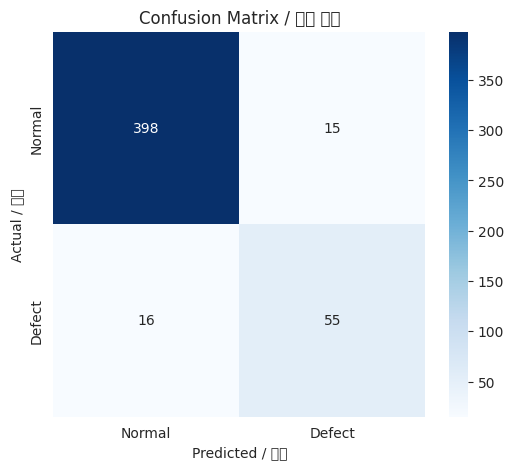

In [55]:
# ============================================================
# 모델 평가 / Model Evaluation
# ============================================================
# 검증 데이터에 대한 예측 수행 / Perform predictions on validation data
y_pred = model.predict(X_valid_final)  # 클래스 예측 / Class prediction
y_pred_proba = model.predict_proba(X_valid_final)[:, 1]  # 확률 예측 / Probability prediction

# 주요 평가 지표 출력 / Print key evaluation metrics
print('=' * 40)
print('검증 데이터 성능 / Validation Performance')
print('=' * 40)
print(f'Accuracy (정확도):  {accuracy_score(y_valid_final, y_pred):.4f}')
print(f'Precision (정밀도): {precision_score(y_valid_final, y_pred):.4f}')
print(f'Recall (재현율):    {recall_score(y_valid_final, y_pred):.4f}')
print(f'F1-Score:           {f1_score(y_valid_final, y_pred):.4f}')
print(f'ROC-AUC:            {roc_auc_score(y_valid_final, y_pred_proba):.4f}')

# 상세 분류 리포트 / Detailed classification report
print('\n' + classification_report(y_valid_final, y_pred, target_names=['Normal', 'Defect']))

# ============================================================
# 혼동 행렬 시각화 / Confusion Matrix Visualization
# ============================================================
# 혼동 행렬: 실제 vs 예측 클래스의 분포
# Confusion Matrix: Distribution of actual vs predicted classes
cm = confusion_matrix(y_valid_final, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Normal', 'Defect'],
    yticklabels=['Normal', 'Defect']
)
plt.title('Confusion Matrix / 혼동 행렬')
plt.xlabel('Predicted / 예측')
plt.ylabel('Actual / 실제')
plt.show()

Top 10 Features (상위 10개 피처):
           feature  importance
   last_maint_days    0.132304
machine_age_months    0.096811
     vibration_rms    0.074608
             pca_3    0.053137
       supplier_S1    0.048436
       supplier_S3    0.045102
       supplier_S2    0.038527
material_grade_M_B    0.036892
     cluster_label    0.034568
material_grade_M_C    0.028452


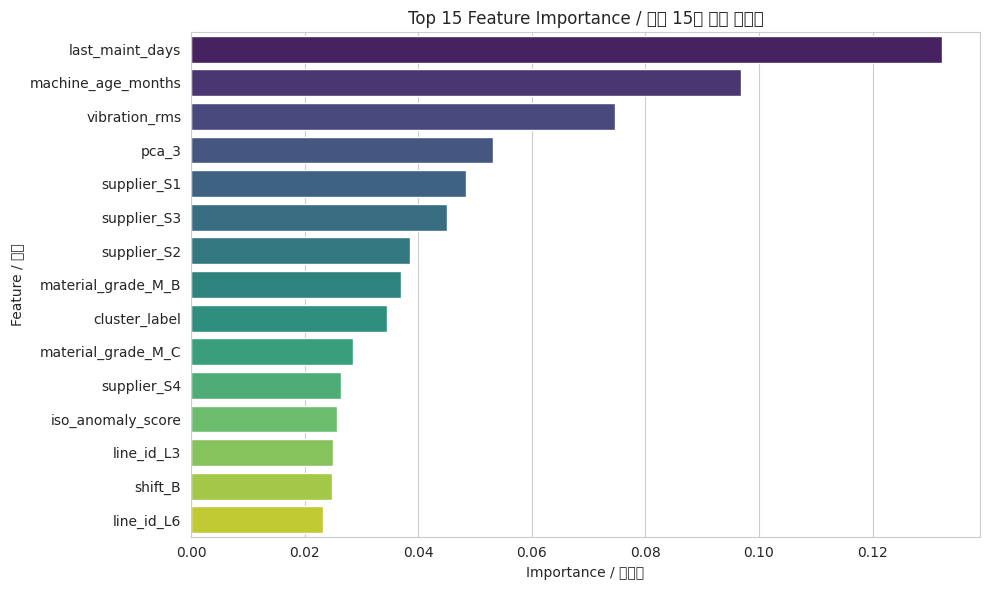

In [56]:
# ============================================================
# 특성 중요도 분석 / Feature Importance Analysis
# ============================================================
# XGBoost의 feature_importances_ 속성으로 각 피처의 기여도 확인
# Check each feature's contribution using XGBoost's feature_importances_

# 중요도 데이터프레임 생성 및 정렬
# Create importance dataframe and sort
importance_df = pd.DataFrame({
    'feature': X_train_final.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# 상위 10개 피처 출력 / Print top 10 features
print('Top 10 Features (상위 10개 피처):')
print(importance_df.head(10).to_string(index=False))

# ============================================================
# 상위 15개 피처 시각화 / Visualize Top 15 Features
# ============================================================
plt.figure(figsize=(10, 6))
sns.barplot(
    x='importance', y='feature',
    data=importance_df.head(15),
    palette='viridis'
)
plt.title('Top 15 Feature Importance / 상위 15개 특성 중요도')
plt.xlabel('Importance / 중요도')
plt.ylabel('Feature / 특성')
plt.tight_layout()
plt.show()

---
## 4️⃣ 임계값 탐색 및 이상 판정

In [57]:
# ============================================================
# F1 기준 최적 임계값 탐색 / Find Optimal Threshold by F1 Score
# ============================================================
# Precision-Recall 곡선에서 F1 점수가 최대가 되는 임계값 탐색
# Find threshold that maximizes F1 score on Precision-Recall curve

# PR 곡선 데이터 계산 / Calculate PR curve data
precisions, recalls, thresholds = precision_recall_curve(y_valid_final, y_pred_proba)

# 각 임계값에서 F1 점수 계산 / Calculate F1 score at each threshold
# F1 = 2 * (Precision * Recall) / (Precision + Recall)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)  # 0 나눗셈 방지 / Prevent div by 0

# 최대 F1 인덱스 및 해당 임계값 / Find max F1 index and corresponding threshold
best_idx = np.argmax(f1_scores[:-1])  # 마지막 요소 제외 / Exclude last element
best_threshold_f1 = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print('=' * 50)
print('F1 최적 임계값 탐색 결과 / F1 Optimal Threshold Results')
print('=' * 50)
print(f'최적 임계값 / Optimal Threshold: {best_threshold_f1:.4f}')
print(f'Best F1: {best_f1:.4f}')
print(f'Precision: {precisions[best_idx]:.4f}')
print(f'Recall: {recalls[best_idx]:.4f}')

F1 최적 임계값 탐색 결과 / F1 Optimal Threshold Results
최적 임계값 / Optimal Threshold: 0.4325
Best F1: 0.7919
Precision: 0.7564
Recall: 0.8310


In [58]:
# ============================================================
# Top 5% 기준 임계값 / Top 5% Threshold
# ============================================================
# 예측 확률 상위 5%를 이상으로 판정하는 임계값
# Threshold that classifies top 5% of prediction probabilities as anomalies
# 운영 환경에서 검사 역량에 맞춰 조정 가능한 정책 기반 접근법
# Policy-based approach adjustable to inspection capacity in operations

# 95 백분위수 = 상위 5% 기준 / 95th percentile = top 5% threshold
threshold_top5 = np.percentile(y_pred_proba, 95)

# Top 5% 기준 예측 / Predictions using top 5% threshold
y_pred_top5 = (y_pred_proba >= threshold_top5).astype(int)

# 성능 평가 / Performance evaluation
prec_top5 = precision_score(y_valid_final, y_pred_top5)
rec_top5 = recall_score(y_valid_final, y_pred_top5)
f1_top5 = f1_score(y_valid_final, y_pred_top5)

print('=' * 50)
print('Top 5% 임계값 결과 / Top 5% Threshold Results')
print('=' * 50)
print(f'임계값 / Threshold: {threshold_top5:.4f}')
print(f'Precision (정밀도): {prec_top5:.4f}')
print(f'Recall (재현율): {rec_top5:.4f}')
print(f'F1-Score: {f1_top5:.4f}')

Top 5% 임계값 결과 / Top 5% Threshold Results
임계값 / Threshold: 0.9878
Precision (정밀도): 0.9600
Recall (재현율): 0.3380
F1-Score: 0.5000


임계값 정책 비교 / Threshold Policy Comparison:
   Metric F1 Optimal Top 5%
Threshold     0.4325 0.9878
Precision     0.7564 0.9600
   Recall     0.8310 0.3380
 F1-Score     0.7919 0.5000


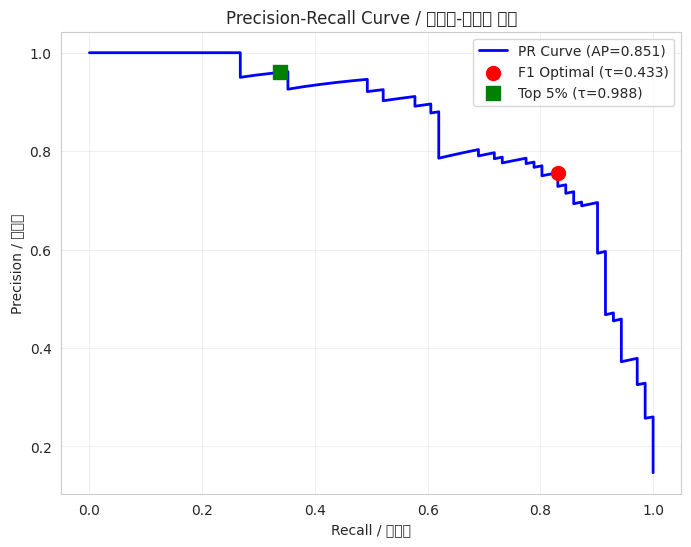

In [59]:
# ============================================================
# 두 임계값 기준 비교 / Compare Two Threshold Policies
# ============================================================
# F1 Optimal: 모델 성능 최적화 관점 / Optimizes model performance
# Top 5%: 운영 제약(검사 역량) 고려 관점 / Considers operational constraints

# F1 최적 임계값 기준 예측 / Predictions using F1 optimal threshold
y_pred_f1_opt = (y_pred_proba >= best_threshold_f1).astype(int)

# 비교 테이블 생성 / Create comparison table
comparison = pd.DataFrame({
    'Metric': ['Threshold', 'Precision', 'Recall', 'F1-Score'],
    'F1 Optimal': [
        f'{best_threshold_f1:.4f}',
        f'{precision_score(y_valid_final, y_pred_f1_opt):.4f}',
        f'{recall_score(y_valid_final, y_pred_f1_opt):.4f}',
        f'{f1_score(y_valid_final, y_pred_f1_opt):.4f}'
    ],
    'Top 5%': [
        f'{threshold_top5:.4f}',
        f'{prec_top5:.4f}',
        f'{rec_top5:.4f}',
        f'{f1_top5:.4f}'
    ]
})
print('임계값 정책 비교 / Threshold Policy Comparison:')
print(comparison.to_string(index=False))

# ============================================================
# Precision-Recall 곡선 시각화 / Precision-Recall Curve Visualization
# ============================================================
plt.figure(figsize=(8, 6))

# PR 곡선 플롯 / Plot PR curve
ap = average_precision_score(y_valid_final, y_pred_proba)
plt.plot(recalls, precisions, 'b-', lw=2, label=f'PR Curve (AP={ap:.3f})')

# F1 최적 지점 표시 / Mark F1 optimal point
plt.scatter(
    [recalls[best_idx]], [precisions[best_idx]],
    c='red', s=100, zorder=5,
    label=f'F1 Optimal (τ={best_threshold_f1:.3f})'
)

# Top 5% 지점 표시 / Mark Top 5% point
idx_top5 = np.argmin(np.abs(thresholds - threshold_top5))
plt.scatter(
    [recalls[idx_top5]], [precisions[idx_top5]],
    c='green', s=100, marker='s', zorder=5,
    label=f'Top 5% (τ={threshold_top5:.3f})'
)

plt.xlabel('Recall / 재현율')
plt.ylabel('Precision / 정밀도')
plt.title('Precision-Recall Curve / 정밀도-재현율 곡선')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.show()

---
## 5️⃣ 이상 샘플 리포트 출력

In [60]:
# ============================================================
# 상위 5% 이상 샘플 추출 / Extract Top 5% Anomaly Samples
# ============================================================
# 운영 현장에 제공할 이상 판정 리포트 생성
# Generate anomaly report for operations team

# 리포트용 데이터프레임 구성 / Compose report dataframe
report_df = X_valid_orig_clean[CAT_COLS].copy()  # 범주형 원본값 / Original categorical values
report_df['score'] = y_pred_proba  # 이상 확률 점수 / Anomaly probability score
report_df['eol_fail'] = y_valid_final.values  # 실제 라벨 / Actual label

# 상위 5% 임계값 적용 / Apply top 5% threshold
threshold_5pct = np.percentile(y_pred_proba, 95)
anomaly_df = report_df[report_df['score'] >= threshold_5pct]

# 점수 기준 내림차순 정렬 / Sort by score descending
anomaly_sorted = anomaly_df.sort_values('score', ascending=False)

# 리포트 요약 출력 / Print report summary
print('=' * 50)
print('이상 샘플 리포트 / Anomaly Sample Report')
print('=' * 50)
print(f'상위 5% 임계값 / Top 5% Threshold: {threshold_5pct:.4f}')
print(f'이상 판정 샘플 / Flagged as anomaly: {len(anomaly_sorted)}개')
print(f'실제 불량 (TP) / True Positives: {anomaly_sorted["eol_fail"].sum()}개')
print(f'오탐 (FP) / False Positives: {(anomaly_sorted["eol_fail"]==0).sum()}개')

이상 샘플 리포트 / Anomaly Sample Report
상위 5% 임계값 / Top 5% Threshold: 0.9878
이상 판정 샘플 / Flagged as anomaly: 25개
실제 불량 (TP) / True Positives: 24개
오탐 (FP) / False Positives: 1개


In [61]:
# ============================================================
# 상위 30건 이상 샘플 상세 출력 / Print Top 30 Anomaly Samples Detail
# ============================================================
# 운영자가 우선 점검해야 할 샘플 리스트
# List of samples for operators to inspect first

output_cols = ['line_id', 'shift', 'supplier', 'material_grade', 'score', 'eol_fail']
top_30 = anomaly_sorted[output_cols].head(30).copy()

# 점수 소수점 6자리로 반올림 / Round score to 6 decimal places
top_30['score'] = top_30['score'].round(6)

print('상위 30건 이상 샘플 / Top 30 Anomaly Samples:')
print(top_30.to_string())

상위 30건 이상 샘플 / Top 30 Anomaly Samples:
    line_id shift supplier material_grade     score  eol_fail
404      L1     A       S4            M_A  0.999784         1
161      L5     B       S1            M_A  0.999624         1
369      L6     C       S1            M_C  0.999542         1
299      L2     B       S3            M_B  0.999449         1
129      L1     A       S3            M_A  0.999442         1
31       L5     A       S3            M_A  0.999312         1
309      L3     B       S2            M_A  0.999208         1
68       L3     A       S3            M_A  0.999098         1
420      L4     A       S4            M_A  0.998626         1
141      L3     C       S3            M_A  0.998491         1
354      L3     A       S4            M_A  0.998411         1
158      L5     A       S2            M_A  0.998403         1
256      L2     B       S4            M_C  0.997561         1
452      L5     C       S4            M_B  0.997330         1
260      L4     A       S1     

In [62]:
# ============================================================
# 이상 샘플 패턴 분석 / Anomaly Pattern Analysis
# ============================================================
# 이상으로 판정된 샘플들의 범주별 분포 분석
# Analyze distribution of flagged anomaly samples by category
# 특정 라인, 교대조, 공급업체에 불량이 집중되는지 확인
# Check if defects concentrate on specific lines, shifts, or suppliers

print('=' * 50)
print('범주별 이상 샘플 분포 / Anomaly Distribution by Category')
print('=' * 50)

for col in CAT_COLS:
    print(f'\n[{col}]')
    value_counts = anomaly_sorted[col].value_counts()
    for val, cnt in value_counts.items():
        pct = cnt / len(anomaly_sorted) * 100
        print(f'  {val}: {cnt}개 ({pct:.1f}%) / {cnt} samples ({pct:.1f}%)')

범주별 이상 샘플 분포 / Anomaly Distribution by Category

[line_id]
  L4: 6개 (24.0%) / 6 samples (24.0%)
  L5: 5개 (20.0%) / 5 samples (20.0%)
  L3: 5개 (20.0%) / 5 samples (20.0%)
  L2: 4개 (16.0%) / 4 samples (16.0%)
  L6: 3개 (12.0%) / 3 samples (12.0%)
  L1: 2개 (8.0%) / 2 samples (8.0%)

[shift]
  A: 13개 (52.0%) / 13 samples (52.0%)
  B: 8개 (32.0%) / 8 samples (32.0%)
  C: 4개 (16.0%) / 4 samples (16.0%)

[supplier]
  S1: 9개 (36.0%) / 9 samples (36.0%)
  S3: 7개 (28.0%) / 7 samples (28.0%)
  S4: 5개 (20.0%) / 5 samples (20.0%)
  S2: 4개 (16.0%) / 4 samples (16.0%)

[material_grade]
  M_A: 16개 (64.0%) / 16 samples (64.0%)
  M_B: 6개 (24.0%) / 6 samples (24.0%)
  M_C: 3개 (12.0%) / 3 samples (12.0%)


In [63]:
# ============================================================
# 최종 결과 요약 / Final Results Summary
# ============================================================
# 전체 분석 파이프라인 요약 및 핵심 성과 지표
# Summary of entire analysis pipeline and key performance metrics

roc_auc = roc_auc_score(y_valid_final, y_pred_proba)
f1_default = f1_score(y_valid_final, y_pred)

print('=' * 60)
print('최종 결과 요약 / Final Results Summary')
print('=' * 60)

# 데이터 개요 / Data overview
print(f'\n📊 데이터 / Data:')
print(f'   전체 {len(df):,}개 (Train: {len(X_train_final)}, Valid: {len(X_valid_final)})')
print(f'   Total {len(df):,} (Train: {len(X_train_final)}, Valid: {len(X_valid_final)})')
print(f'   불균형 비율 / Imbalance ratio: {imbalance_ratio:.2f}:1')

# 전처리 / Preprocessing
print(f'\n🔧 전처리 / Preprocessing:')
print(f'   StandardScaler + One-Hot Encoding + IQR Outlier Removal')

# 비지도 특성 / Unsupervised features
print(f'\n🔬 비지도 잠재 특성 / Unsupervised Latent Features:')
print(f'   PCA(3) + IsolationForest(1) + KMeans(2) = 6 features')

# 모델 / Model
print(f'\n🤖 모델 / Model:')
print(f'   XGBoost (SMOTE + scale_pos_weight={scale_pos_weight:.2f})')

# 성능 / Performance
print(f'\n📈 성능 / Performance:')
print(f'   ROC-AUC: {roc_auc:.4f}')
print(f'   F1 (τ=0.5): {f1_default:.4f}')
print(f'   F1 (optimal): {best_f1:.4f}')

# 임계값 / Thresholds
print(f'\n🎯 임계값 / Thresholds:')
print(f'   F1 Optimal: {best_threshold_f1:.4f}')
print(f'   Top 5%: {threshold_top5:.4f}')

# 이상 탐지 결과 / Anomaly detection results
print(f'\n🚨 이상 탐지 / Anomaly Detection (Top 5%):')
print(f'   판정 {len(anomaly_sorted)}개 중 실제 불량 {anomaly_sorted["eol_fail"].sum()}개')
print(f'   {len(anomaly_sorted)} flagged, {anomaly_sorted["eol_fail"].sum()} true defects')

print('\n' + '=' * 60)
print('✅ 분석 완료 / Analysis Completed')
print('=' * 60)

최종 결과 요약 / Final Results Summary

📊 데이터 / Data:
   전체 2,500개 (Train: 1933, Valid: 484)
   Total 2,500 (Train: 1933, Valid: 484)
   불균형 비율 / Imbalance ratio: 5.67:1

🔧 전처리 / Preprocessing:
   StandardScaler + One-Hot Encoding + IQR Outlier Removal

🔬 비지도 잠재 특성 / Unsupervised Latent Features:
   PCA(3) + IsolationForest(1) + KMeans(2) = 6 features

🤖 모델 / Model:
   XGBoost (SMOTE + scale_pos_weight=5.78)

📈 성능 / Performance:
   ROC-AUC: 0.9599
   F1 (τ=0.5): 0.7801
   F1 (optimal): 0.7919

🎯 임계값 / Thresholds:
   F1 Optimal: 0.4325
   Top 5%: 0.9878

🚨 이상 탐지 / Anomaly Detection (Top 5%):
   판정 25개 중 실제 불량 24개
   25 flagged, 24 true defects

✅ 분석 완료 / Analysis Completed
